In [136]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
import numpy as np


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_inv, p):  # S is the matrix such that ||S @ Dx||\leq delta. As a consequence, S_inv appears in the unconstrained problem
        m, n = X.shape
        q = compute_q(p)
        # Formulate problem
        param = cp.Variable(n)
        param_norm = cp.pnorm(S_inv @ param, p=q)
        adv_radius = cp.Parameter(name='adv_radius', nonneg=True)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / m * cp.sum((abs_error + adv_radius * param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius = adv_radius
        self.param = param
        self.warm_start = False

    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, **kwargs)
            v = self.param.value
        except:
            v = np.zeros(self.param.shape)
        return v


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        print(coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T


def plot_coefs(alphas, coefs, ax):
    colors = cycle(["b", "r", "g", "c", "k"])
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    colors = cycle(["b", "r", "g", "c", "k"])
    l1norm = np.abs(coefs).mean(axis=0)
    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)

#X, y = datasets.load_diabetes(return_X_y=True)
#print(X.shape, y.shape)
# Standardize data


#M = np.sum(masks, axis=1)
#X_nan = X.copy()
#X_nan[masks == 1] = np.nan

#X = multiple_imputation(1, X_nan)
print("end block")


end block


In [124]:
# imputation's block

def clear_dataset(x, masks):
  # remove observations full NaN
  M = np.sum(1 - masks, axis=1) > 0
  return x[M, :], masks[M, :]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res = ice.fit_transform(X_nan)
       #print("fin res ", res)
       return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      #print(m_bool)
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      #print("matrices computed")
      #print(sigma_aa_inv)
      #print(sigma_ma)
      #print("wee", x_c[m_bool])
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      #print("mu cond ", mu_cond)
      x_imp[i, ~m_bool] = mu_cond
    #print("x_orig \n", x)
    #print("x_imp \n", x_imp)
    #print("diff\n", x - x_imp)
  return x_imp

n = 3
d = 4
S = np.random.randint(low=1, high=10, size=(d, d))
S = S.T @ S * 0 + np.eye(d)
#print(S)
muu = np.array([10, 20, 30, 40])
xx = np.random.randint(low=1, high=6, size=(n, d))
mm = np.array([[0, 0, 0, 0], [1, 1, 1, 1], [0, 0, 1, 1]])
#print(xx)
#print(mm)
x, m = clear_dataset(xx, mm)
#print("cleaned ds \n", x)
#print("cleaned masks \n", mm)
res = imputation_elliptic(muu, S, x, m)


2 4


In [128]:
# define observations

n = 300
d = 8
X_orig = np.random.rand(n, d)
#X -= X.mean(axis=0)
#X /= X.std(axis=0)
b = np.random.rand(d)

#L = np.linalg.cholesky(S)  # return L such that S = LL.T
#L_inv = np.linalg.inv(L)
#S_inv = L_inv.T @ L_inv

masks = np.random.binomial(1, 0.25, (n, d))  # 1 missing, 0 seen

X_orig, masks = clear_dataset(X_orig, masks)
print("final shape ", X_orig.shape)
y = X_orig @ b
X_nan = X_orig.copy()
X_nan[masks == 1] = np.nan
#print(masks)
#print(X_orig)
#print(X_nan)
print("end block")

final shape  (300, 8)
end block


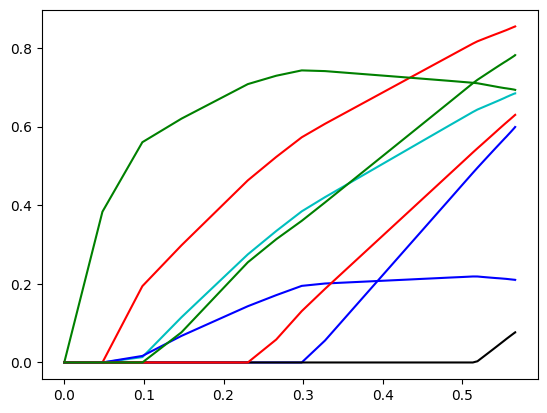

In [129]:
## original lasso
fig, ax = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_orig, y)
plot_coefs_l1norm(coefs_lasso, ax)

  2%|▎         | 5/200 [00:00<00:04, 43.29it/s]

[0.59886864 0.85454019 0.69329789 0.68456767 0.07673443 0.21022693
 0.62990861 0.78166016]
[0.59886866 0.85454025 0.69329792 0.68456768 0.07673438 0.2102269
 0.6299086  0.78166015]
[0.59886866 0.85454028 0.69329794 0.6845677  0.07673432 0.21022684
 0.62990863 0.78166018]
[0.59886865 0.85454026 0.69329797 0.6845677  0.07673432 0.21022682
 0.62990863 0.7816602 ]
[0.59886865 0.85454025 0.69329796 0.68456768 0.07673433 0.21022682
 0.62990864 0.7816602 ]
[0.59886863 0.85454028 0.69329793 0.68456767 0.07673434 0.2102268
 0.62990865 0.78166022]
[0.59886864 0.85454029 0.69329793 0.68456766 0.07673433 0.21022679
 0.62990866 0.7816602 ]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]


  8%|▊         | 16/200 [00:00<00:04, 44.92it/s]

[0.59886851 0.85453977 0.69329747 0.684567   0.07673643 0.21022701
 0.62990896 0.78165948]
[0.59886875 0.85454015 0.69329784 0.68456745 0.07673521 0.21022654
 0.62990871 0.78165992]
[0.59886888 0.85454036 0.69329797 0.68456764 0.07673456 0.21022638
 0.62990868 0.78166017]
[0.59886887 0.85454042 0.69329804 0.68456769 0.07673416 0.21022649
 0.62990868 0.78166026]
[0.59886891 0.85454048 0.69329801 0.68456775 0.07673397 0.21022646
 0.62990871 0.78166032]
[0.59886882 0.85454048 0.6932981  0.68456784 0.07673385 0.21022646
 0.6299087  0.78166042]
[0.59886833 0.85454036 0.69329809 0.68456765 0.07673412 0.21022705
 0.62990877 0.78166025]
[0.59886869 0.85454028 0.69329788 0.68456764 0.07673395 0.21022657
 0.62990958 0.78166016]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886892 0.85454053 0.69329819 0.68456797 0.07673379 0.21022632
 0.62990868 0.78166045]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]

 14%|█▎        | 27/200 [00:00<00:03, 47.43it/s]

[0.59886908 0.85454063 0.69329812 0.68456813 0.07673339 0.21022602
 0.6299087  0.78166093]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454079 0.69329825 0.68456824 0.07673334 0.21022612
 0.62990872 0.78166062]
[0.59886892 0.85454058 0.69329806 0.68456807 0.07673334 0.21022607
 0.62990857 0.78166148]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]

 22%|██▏       | 43/200 [00:00<00:02, 63.38it/s]

[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]

 30%|███       | 60/200 [00:01<00:01, 70.78it/s]

[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]

 39%|███▉      | 78/200 [00:01<00:01, 76.42it/s]

[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]

 47%|████▋     | 94/200 [00:01<00:01, 71.74it/s]

[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]

 51%|█████     | 102/200 [00:01<00:01, 54.25it/s]

[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]


 55%|█████▍    | 109/200 [00:01<00:01, 47.20it/s]

[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]


 61%|██████    | 122/200 [00:02<00:01, 53.32it/s]

[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]

 64%|██████▍   | 128/200 [00:02<00:01, 53.00it/s]

[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]


 70%|███████   | 140/200 [00:02<00:01, 47.27it/s]

[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329823 0.68456822 0.07673343 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673343 0.21022611
 0.62990872 0.78166061]
[0.59886896 0.85454078 0.69329824 0.68456822 0.07673343 0.21022611
 0.62990872 0.78166061]


 72%|███████▎  | 145/200 [00:02<00:01, 46.97it/s]

[0.59886897 0.85454078 0.69329823 0.68456823 0.07673343 0.21022611
 0.62990873 0.78166061]
[0.59886896 0.85454078 0.69329823 0.68456822 0.07673343 0.21022611
 0.62990872 0.78166061]
[0.59886895 0.85454077 0.69329824 0.68456822 0.07673342 0.21022611
 0.62990871 0.7816606 ]
[0.59886894 0.85454077 0.69329824 0.68456822 0.07673341 0.21022611
 0.62990871 0.7816606 ]


/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


[1.15954121e-01 7.63943481e-01 9.82229473e-01 6.18551576e-01
 1.05697315e-05 2.93143869e-01 2.61902307e-01 6.36772080e-01]
[-1.14916498e-15  2.67506426e-01  7.90103798e-01  1.22288568e-01
 -1.12945143e-15  2.04088700e-01 -1.27704254e-15  4.11390100e-02]


 75%|███████▌  | 150/200 [00:03<00:03, 15.33it/s]

[4.70249757e-06 4.89941449e-06 5.13162892e-06 4.92099996e-06
 4.83077834e-06 5.10718709e-06 4.72554614e-06 4.86794692e-06]
[2.66558708e-19 2.79491515e-19 2.91265867e-19 2.79662549e-19
 2.74716087e-19 2.90070495e-19 2.68704930e-19 2.77445495e-19]
[2.75496785e-19 2.86267185e-19 2.98646652e-19 2.86418870e-19
 2.79796234e-19 2.97397994e-19 2.75103198e-19 2.83196671e-19]
[2.81403415e-19 2.93259131e-19 3.06136959e-19 2.92635287e-19
 2.88041239e-19 3.05014832e-19 2.82401669e-19 2.90461655e-19]


 77%|███████▋  | 154/200 [00:04<00:03, 12.14it/s]

[2.87785388e-19 3.02616817e-19 3.14990798e-19 3.01105738e-19
 2.94928612e-19 3.13332192e-19 2.90988843e-19 2.98415879e-19]
[2.97094345e-19 3.10262008e-19 3.24453561e-19 3.10974905e-19
 3.05330868e-19 3.21351405e-19 2.99517969e-19 3.07398286e-19]


 78%|███████▊  | 157/200 [00:04<00:03, 10.86it/s]

[3.06645986e-19 3.18369090e-19 3.33393481e-19 3.20183676e-19
 3.14270883e-19 3.34163959e-19 3.07327487e-19 3.17553366e-19]
[3.16388631e-19 3.29518575e-19 3.47384051e-19 3.29982653e-19
 3.24204534e-19 3.46001956e-19 3.18189662e-19 3.26690476e-19]
[3.27056000e-19 3.42457439e-19 3.57534613e-19 3.43029669e-19
 3.35261239e-19 3.56896115e-19 3.30475921e-19 3.39872932e-19]
[0. 0. 0. 0. 0. 0. 0. 0.]


 80%|████████  | 160/200 [00:05<00:05,  6.80it/s]

[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]


 81%|████████  | 162/200 [00:06<00:06,  5.52it/s]

[3.21640775e-19 3.33637409e-19 3.51430702e-19 3.36226799e-19
 3.28049423e-19 3.48160768e-19 3.22152833e-19 3.32636496e-19]
[3.01318293e-19 3.14231242e-19 3.28666001e-19 3.15442587e-19
 3.08324165e-19 3.28266999e-19 3.02264514e-19 3.12291111e-19]


 82%|████████▏ | 164/200 [00:06<00:06,  5.27it/s]

[2.81868264e-19 2.92167903e-19 3.04948870e-19 2.93625759e-19
 2.87345609e-19 3.03644138e-19 2.82174376e-19 2.90721610e-19]


 82%|████████▎ | 165/200 [00:06<00:06,  5.12it/s]

[2.58961115e-19 2.71253468e-19 2.83331080e-19 2.73288537e-19
 2.67965313e-19 2.82030350e-19 2.60370326e-19 2.69261442e-19]


 83%|████████▎ | 166/200 [00:07<00:07,  4.74it/s]

[2.38379666e-19 2.47289224e-19 2.58921496e-19 2.48210269e-19
 2.44665884e-19 2.56417259e-19 2.39009406e-19 2.46667455e-19]


 84%|████████▎ | 167/200 [00:07<00:07,  4.28it/s]

[2.11876871e-19 2.23012734e-19 2.33843631e-19 2.22894040e-19
 2.19505116e-19 2.32224583e-19 2.12802538e-19 2.20299831e-19]


 84%|████████▍ | 168/200 [00:07<00:08,  3.95it/s]

[1.86807383e-19 1.96393359e-19 2.02823240e-19 1.95695582e-19
 1.91489691e-19 2.02244904e-19 1.88683513e-19 1.92949917e-19]


 84%|████████▍ | 169/200 [00:08<00:08,  3.60it/s]

[1.57148332e-19 1.65990348e-19 1.72990106e-19 1.66486667e-19
 1.62376267e-19 1.72608297e-19 1.59948791e-19 1.62905783e-19]


 85%|████████▌ | 170/200 [00:08<00:08,  3.46it/s]

[1.27028548e-19 1.33700847e-19 1.38218465e-19 1.33965627e-19
 1.30704576e-19 1.39137502e-19 1.29148835e-19 1.32508614e-19]


 86%|████████▌ | 171/200 [00:08<00:08,  3.36it/s]

[9.30684109e-20 9.87998883e-20 1.02886602e-19 9.88367247e-20
 9.80191050e-20 1.02293418e-19 9.40627663e-20 9.75095487e-20]


 86%|████████▌ | 172/200 [00:09<00:08,  3.42it/s]

[5.63894155e-20 5.90586891e-20 6.16801148e-20 5.92616782e-20
 5.89412973e-20 6.30950113e-20 5.71168716e-20 5.78914617e-20]


 86%|████████▋ | 173/200 [00:09<00:07,  3.42it/s]

[1.80559125e-20 1.90913254e-20 1.83007764e-20 1.96774647e-20
 1.79162211e-20 1.91466372e-20 1.84962176e-20 1.87334036e-20]


 87%|████████▋ | 174/200 [00:09<00:07,  3.40it/s]

[-2.51256155e-20 -2.45033899e-20 -2.77278450e-20 -2.64431100e-20
 -2.51577885e-20 -2.47874796e-20 -2.48175892e-20 -2.62876842e-20]


 88%|████████▊ | 175/200 [00:10<00:07,  3.14it/s]

[-6.84077639e-20 -7.04994690e-20 -7.62149390e-20 -7.09821134e-20
 -7.05756143e-20 -7.36436482e-20 -6.86137503e-20 -7.03310552e-20]


 88%|████████▊ | 176/200 [00:10<00:08,  2.92it/s]

[-1.13348216e-19 -1.16360977e-19 -1.22666532e-19 -1.17656539e-19
 -1.18179859e-19 -1.23307514e-19 -1.14799809e-19 -1.18783103e-19]


 88%|████████▊ | 177/200 [00:11<00:10,  2.29it/s]

[9.73800511e-07 1.01355691e-06 1.06570766e-06 1.02203170e-06
 1.00279792e-06 1.05789886e-06 9.82134831e-07 1.01180378e-06]


 89%|████████▉ | 178/200 [00:11<00:10,  2.03it/s]

[-1.90379621e-19 -1.98408469e-19 -2.09702164e-19 -2.01187190e-19
 -1.97462769e-19 -2.09317996e-19 -1.94646234e-19 -1.98758950e-19]


 90%|████████▉ | 179/200 [00:12<00:11,  1.82it/s]

[3.00254439e-07 3.12064669e-07 3.29953813e-07 3.16458723e-07
 3.10283472e-07 3.26320091e-07 3.04420999e-07 3.13650608e-07]


 90%|█████████ | 180/200 [00:13<00:12,  1.65it/s]

[8.16350115e-08 8.52404045e-08 8.84115688e-08 8.47773217e-08
 8.33259690e-08 8.85803403e-08 8.12343974e-08 8.36624028e-08]


 90%|█████████ | 181/200 [00:13<00:11,  1.70it/s]

[5.93090635e-07 6.17401735e-07 6.48746128e-07 6.22153947e-07
 6.10495871e-07 6.44275686e-07 5.97788405e-07 6.15838144e-07]


 91%|█████████ | 182/200 [00:14<00:09,  1.86it/s]

[0. 0. 0. 0. 0. 0. 0. 0.]


 92%|█████████▏| 183/200 [00:14<00:08,  1.98it/s]

[1.00691861e-06 1.04867398e-06 1.10002827e-06 1.05490369e-06
 1.03536417e-06 1.09369112e-06 1.01328521e-06 1.04384928e-06]


 92%|█████████▏| 184/200 [00:15<00:07,  2.10it/s]

[0. 0. 0. 0. 0. 0. 0. 0.]


 92%|█████████▎| 185/200 [00:15<00:06,  2.20it/s]

[1.45770735e-07 1.51583281e-07 1.59928772e-07 1.53384126e-07
 1.50431767e-07 1.58396770e-07 1.47485489e-07 1.51949991e-07]


 93%|█████████▎| 186/200 [00:15<00:06,  2.25it/s]

[0. 0. 0. 0. 0. 0. 0. 0.]


 94%|█████████▎| 187/200 [00:16<00:05,  2.31it/s]

[0. 0. 0. 0. 0. 0. 0. 0.]


 94%|█████████▍| 188/200 [00:16<00:05,  2.32it/s]

[0. 0. 0. 0. 0. 0. 0. 0.]


 94%|█████████▍| 189/200 [00:17<00:04,  2.34it/s]

[0. 0. 0. 0. 0. 0. 0. 0.]


 95%|█████████▌| 190/200 [00:17<00:04,  2.38it/s]

[0. 0. 0. 0. 0. 0. 0. 0.]


 96%|█████████▌| 191/200 [00:17<00:03,  2.37it/s]

[0. 0. 0. 0. 0. 0. 0. 0.]


 96%|█████████▌| 191/200 [00:18<00:00, 10.40it/s]

None


TypeError: only integer scalar arrays can be converted to a scalar index

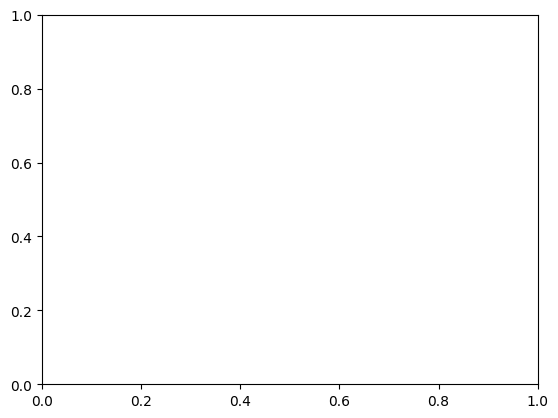

In [134]:
# training with original dataset X_orig
fig, ax = plt.subplots(num='advtrain_linf')
linfadvtrain = AdversarialTraining(X_orig, y, np.eye(X_orig.shape[1]), p=np.inf)
estimator = lambda X, y, a:  linfadvtrain(adv_radius=a)
alphas_adv, coefs_advtrain_linf  = get_path(X_orig, y, estimator, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf, ax)

In [ ]:
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
#print("S_inv std_rf \n", np.diag(1 / sd_rf))
#print("diag matr std \n", np.diag(sd_rf))
#print(X_orig)
#print(masks)
#print(X_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)


In [ ]:
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)
#print("S_inv std_rf \n", np.diag(1 / sd_rf))
#print("diag matr std \n", np.diag(sd_rf))
#print(X_orig)
#print(masks)
#print(X_rf)
fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)

In [ ]:
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

#print("S_inv std_rf \n", np.diag(1 / sd_rf))
#print("diag matr std \n", np.diag(sd_rf))
#print(X_orig)
#print(masks)
#print(X_rf)
fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)


In [ ]:
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
delta = np.mean(masks) # parameter missingness
print(delta)
X_0 = np.nan_to_num(X_nan)
S_ellp =  X_0.T @ X_0
#print("diag ", np.diag(np.diag(S)))
S_ellp = (1/d - 1/(d**2)) * np.diag(np.diag(S_ellp)) + 1/(d**2) * S_ellp
#print("matrix \n", S_ellp)
print(np.linalg.eigvalsh(S_ellp))
#print("X_nan\n", X_nan)
#print(masks)
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#print(X_ellp)
S_inv_ellp = np.linalg.inv(S_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_inv_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
